In [5]:
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import numpy as np
from kymatio.scattering2d.core.scattering2d import scattering2d
import matplotlib.pyplot as plt
import torch
import torchvision
from kymatio import Scattering2D
from PIL import Image
from IPython.display import display 
from torchvision.transforms import *

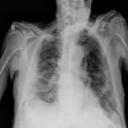

In [36]:
#img = Image.open('/NOBACKUP/gauthiers/KTH/sample_a/wood/54a-scale_10_im_10_col.png')
img = Image.open('/NOBACKUP/gauthiers/chest_xrays_preprocess/train/positive/MIDRC-RICORD-1C-SITE2-000216-21074-0.png')
rsz_transf = torchvision.transforms.Resize((128,128))
img = rsz_transf(img)
display(img)

Rotation

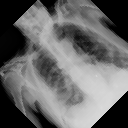

In [37]:
transformation = torchvision.transforms.RandomRotation(degrees = 45)
transformation.degrees = [45,45]
img_rot2 = transformation(img)
display(img_rot2)

Blur

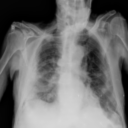

In [38]:
transformation = torchvision.transforms.GaussianBlur(3)
img_blur = transformation(img)
display(img_blur)

Perspective

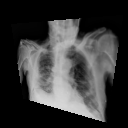

In [39]:
transformation = torchvision.transforms.RandomPerspective()
img_rdmPersp = transformation(img)
display(img_rdmPersp)

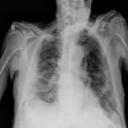

In [40]:
transforms = torchvision.transforms.RandomPerspective(distortion_scale=0.5)
img_1 = transforms(img)
display(img_1)


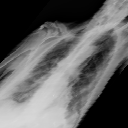

In [41]:
transforms = torchvision.transforms.RandomAffine(degrees = 0, shear=90)
img_2 = transforms(img)
display(img_2)


À la Mallat

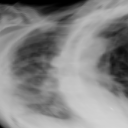

tensor(0.8367)

In [177]:
# def tau(u):
#     print(u)
#     return [0.5*u[0]+0.5*u[1]**2,0.3*u[1]]
#tau = lambda u : 0.2*u
#tau = lambda u : [0.5*u[0]+0.5*u[1]**2,0.3*u[1]] #la fonction tau de Mallat
#tau_mat = lambda u : torch.tensor([[vectorize_tau(grid)] for j in range(len(u))] for i in range(len(u))]) #dim x dim x 2
# vectorize_tau = lambda grid : np.vectorize(tau)(grid) #dim x dim x 2 

tau = lambda u : (0.5*u[0]+0.3*u[1]**2,0.3*u[1])
tau_mat = lambda grid : torch.tensor([[tau(grid[i,j,:]) for j in range(len(grid))] for i in range(len(grid))])
def diffeo(img,tau):
    transf = torchvision.transforms.ToTensor()
    img = transf(img).unsqueeze(0)
    dim = img.shape[-1]
    grid = torch.tensor([[[x,y] for x in torch.linspace(-1,1,dim)] for y in torch.linspace(-1,1,dim)])
    grid_transf = (grid - tau_mat(grid)).unsqueeze(0)
    img_transf = torch.nn.functional.grid_sample(img,grid_transf).squeeze(0)
    transf = torchvision.transforms.ToPILImage()
    return transf(img_transf)
img_diffeo = diffeo(img,tau)
display(img_diffeo)

def deformation_size(tau):
    precision = 100
    points = [torch.tensor([x,y]) for x in torch.linspace(-1,1,precision) for y in torch.linspace(-1,1,precision)]
    jac = torch.stack(list(map(lambda point : torch.stack(torch.autograd.functional.jacobian(tau,point)), points)))
    norm_jac = torch.linalg.matrix_norm(jac,dim=(1, 2))
    return torch.max(norm_jac)

deformation_size(tau)